In [ ]:
import pandas as pd
import numpy as np
import os
import random
import warnings
import pandas_profiling
import scipy.stats
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from pathlib import Path

from pandas_profiling import ProfileReport

from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve,fbeta_score,roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix,average_precision_score,make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold,cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures,PowerTransformer,QuantileTransformer,LabelEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

from sklearn.base import clone
from sklearn.impute import KNNImputer
from matplotlib.pyplot import figure
from sklearn.multiclass import OneVsRestClassifier
plt.style.use('ggplot')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [ ]:
!pip3 install pandas-profiling==2.8.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/dataset_57_hypothyroid.csv"
df = pd.read_csv(path,na_values="?",sep=",")
df.tail()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
3767,30.0,F,f,f,f,f,f,f,f,f,f,f,f,t,f,f,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,f,NaN,other,negative
3768,68.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.0,t,2.1,t,124.0,t,1.08,t,114.0,f,NaN,SVI,negative
3769,74.0,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,t,5.1,t,1.8,t,112.0,t,1.07,t,105.0,f,NaN,other,negative
3770,72.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.7,t,2.0,t,82.0,t,0.94,t,87.0,f,NaN,SVI,negative
3771,64.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.0,t,2.2,t,99.0,t,1.07,t,92.0,f,NaN,other,negative


# 1. EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   float64
 1   sex                        3622 non-null   object 
 2   on_thyroxine               3772 non-null   object 
 3   query_on_thyroxine         3772 non-null   object 
 4   on_antithyroid_medication  3772 non-null   object 
 5   sick                       3772 non-null   object 
 6   pregnant                   3772 non-null   object 
 7   thyroid_surgery            3772 non-null   object 
 8   I131_treatment             3772 non-null   object 
 9   query_hypothyroid          3772 non-null   object 
 10  query_hyperthyroid         3772 non-null   object 
 11  lithium                    3772 non-null   object 
 12  goitre                     3772 non-null   object 
 13  tumor                      3772 non-null   objec

In [ ]:
report = pandas_profiling.ProfileReport(df)
#report

**Overview of Profiling:**

1) TBG_measured is 100% false, which means TBG is 100% NaN. Useless features, should be dropped

2) Boolean variables (exluding sex) are very unbalanced, since they are indicating some rare condition (such as pregnancy, tumor, e.t.c), so is the target one.

3)Age has an obvious mistake  (Max age is 422) while other features have an outliars too, but it's hard to say is it mistake or very big value

**Class problem**

Target variable have 4 classes, "negative" and 3 classes of deseased people. Last class "secondary_hypothyroid" contains only 2 variable. 
Since it contain only 2 example in the ENTIRE dataset (which should be also splitted in train/test). Each of the set will contain only one example of data, which is not enough even for upsampling or some other techniques. Dublicating single value will result in model errors and SMOT algorithms cant be perfom using single value. 


In [ ]:
df['Class'].value_counts()

negative                   3481
compensated_hypothyroid     194
primary_hypothyroid          95
secondary_hypothyroid         2
Name: Class, dtype: int64


This class will ruin the model average metric (using the macro one), since classifier can't learn properly on single example. Usingle minor average is solving the problem, but also creating another one -- 92% of the dataset is healthy people, which are easy to correctly predict. Which means this class will dominate the minor metric.

Since there is no way to correctly classify "secondary_hypothyroid" Class (its values are not even extreme ones in terms of numeric features) using only 1 value, the decision is made **to avoid this class**, and build classifier which do not recognizer this type of desease.

In [ ]:
#df.drop(df.index[df['Class'] == 'secondary_hypothyroid'], inplace = True)

In [ ]:
#empty columns
df.drop(columns=["TBG_measured","TBG"],inplace=True)

In [ ]:
BOOLEANS = [col for col in df.select_dtypes(include=['object']).columns.tolist() if col not in ["Class","sex","referral_source"]];

NUMERIC = [col for col in df.select_dtypes(include=['float64']).columns.tolist()];

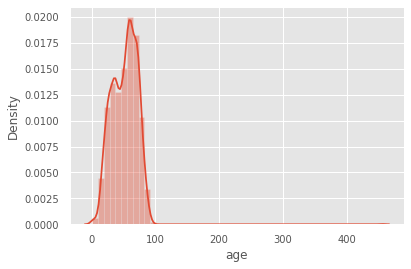

In [ ]:
sns.distplot(df["age"]);

Age has an mistake, not the outliar, therefore deleting the entire row is not needed, we can simply impute new age value.

In [ ]:
MISTAKE_AGE_THRESH = 110

mistakes = df[df["age"]>MISTAKE_AGE_THRESH]["age"]
df["age"].replace([mistakes],np.nan,inplace=True) #filling this values to nan, to impute them later


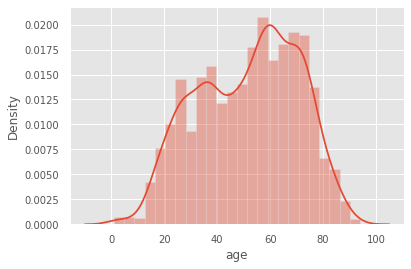

In [ ]:
sns.distplot(df["age"]);

Let's try to see how single boolean feature affect class.

Plot below is showing how many "deseased" targets (percentage) each boolean has per value. 

For the simplicity of the analysis, all hyperthyroids classes are combined in "healthy" one, indicating was the hyperthyroid detected or not


Outliers from numeric features are NOT being removed, because they indicate some blood measurements which can be extremly high in case of hypothyroid

In [ ]:

healthy = df.loc[df["Class"]=="negative"]
deseased = df.loc[df["Class"]!="negative"]

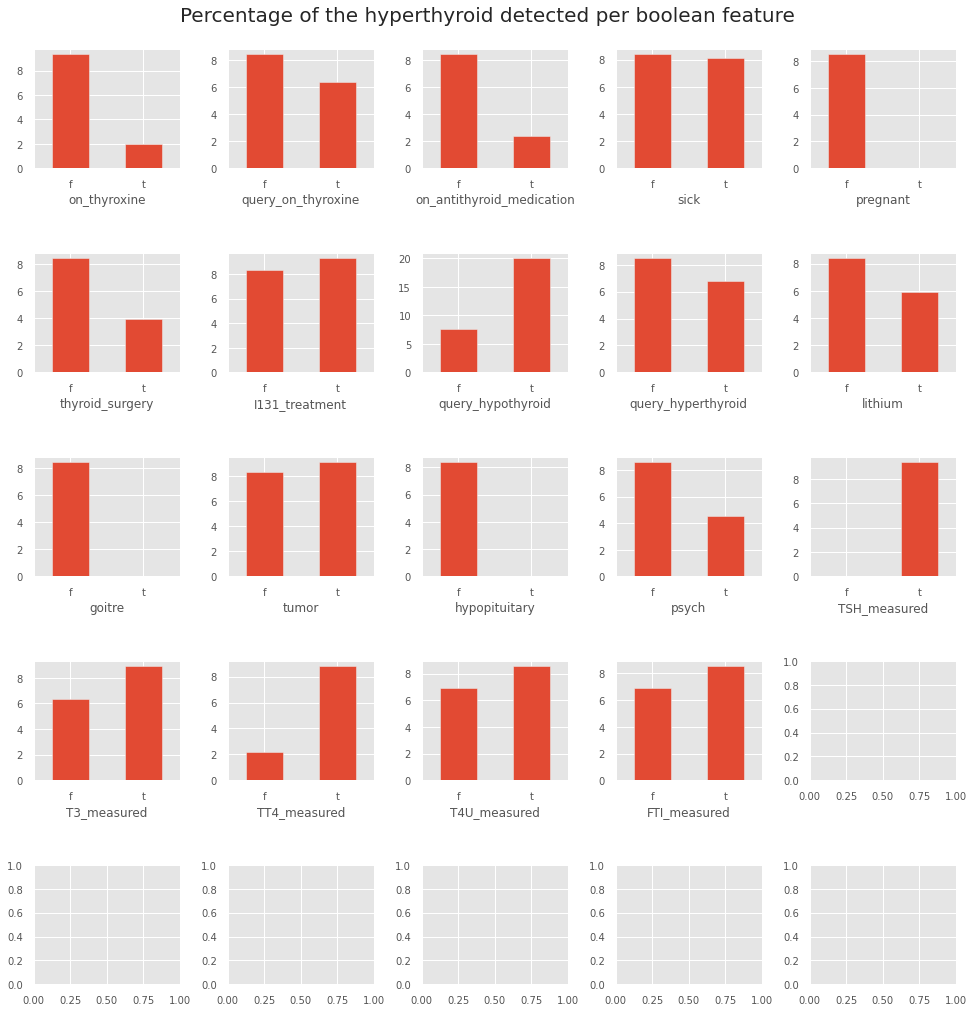

In [ ]:

fig, axes = plt.subplots(nrows=5, ncols=5,figsize=(15, 15));

#semilocon somehow don't stop the output use _ for dropping
_ = fig.suptitle('Percentage of the hyperthyroid detected per boolean feature', fontsize=20); 
_ = fig.tight_layout(pad=6,w_pad=1, h_pad=6);
i = 0;
j = 0;
for col in BOOLEANS:
  if i == 5:
    i = 0;
    j = j+1;
  helth_amount = healthy.groupby(col)['Class'].size();
  deseased_amount = deseased.groupby(col)['Class'].size();
  subplt = (deseased_amount/helth_amount*100).plot.bar(ax=axes[j,i]);
  _ = subplt.set_xticklabels(subplt.get_xticklabels(), rotation=0);
  i = i+1;


This kind of plot help us quickly visually analyze the impact of single boolean variable to target feature.

For exaple, there are equally % of  hyperthyroids detected regardless of "sick" feature, but among people who are on thyroxine is four times more healthy ones.

Though, this plot shouldn't be used to directly estimate feature-importance, because it's considering only single-feature impact. E.g according to this plot "sick" feature is useless, but it can be usefull paired with other feature. Another point that we have very disbalanced classes and some of them have very few rows.There is no deseased people with hypopituitary, but it contains only one value. 

 Referral_source showing big difference between classes, but this feature makes no sense toward detecting hyperthyroid and should be dropped

# 2. Data preporation

Firstly, let's encode "object" to another types

In [ ]:
df["sex"] = df["sex"].map({'F': 0, 'M': 1}); #the patriarchal world itself;

#Categorical tranformations are simple in case of booleans
#for col in BOOLEANS:
#  df[col] = df[col].map({'f': 0, 't': 1});
 #df[col] = df[col].astype('bool'); #saving little bit of memory

In [ ]:
df.dtypes

age                          float64
sex                          float64
on_thyroxine                  object
query_on_thyroxine            object
on_antithyroid_medication     object
sick                          object
pregnant                      object
thyroid_surgery               object
I131_treatment                object
query_hypothyroid             object
query_hyperthyroid            object
lithium                       object
goitre                        object
tumor                         object
hypopituitary                 object
psych                         object
TSH_measured                  object
TSH                          float64
T3_measured                   object
T3                           float64
TT4_measured                  object
TT4                          float64
T4U_measured                  object
T4U                          float64
FTI_measured                  object
FTI                          float64
referral_source               object
C

In [ ]:
df.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,referral_source,Class
0,41.0,0.0,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.30,t,2.5,t,125.0,t,1.14,t,109.0,SVHC,negative
1,23.0,0.0,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.10,t,2.0,t,102.0,f,NaN,f,NaN,other,negative
2,46.0,1.0,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,NaN,t,109.0,t,0.91,t,120.0,other,negative
3,70.0,0.0,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175.0,f,NaN,f,NaN,other,negative
4,70.0,0.0,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61.0,t,0.87,t,70.0,SVI,negative


Only Thyroid Function Tests are missing. Because it's very important features,strings where at least 3 of this numeric indexes are missing at the same time should be deleted, because it will be too hard to correctly impute them

In [ ]:
df.drop(columns=["referral_source"],inplace=True)
df.dropna(thresh = df.columns.size-3,inplace=True)

#Measurement fact is not needed, 
df.drop(columns=["TSH_measured","T3_measured","T4U_measured","TT4_measured","FTI_measured"],inplace=True)

In [ ]:
#upd
BOOLEANS = [col for col in df.select_dtypes(include=['object']).columns.tolist() if col not in ["Class","sex","referral_source"]];

In [ ]:
df.isna().sum()

age                            2
sex                          137
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          165
T3                           570
TT4                            6
T4U                          161
FTI                          159
Class                          0
dtype: int64

In [ ]:
#let's separate train/test
TARGET = "Class";
SEED = 42;
target = df[TARGET].values
X_train, X_test, y_train, y_test = train_test_split(df.drop(TARGET, axis=1), target, 
                                                  random_state=SEED, shuffle=True, stratify=df[TARGET], test_size = 0.2)

In [ ]:
#feature encoding 

numeric_transformer = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler()),
    ])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ])

booleans_transformer = OrdinalEncoder() #boolean case 0 and 1 value -- just fine

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC),
        ('cat', categorical_transformer, ["sex"]),
        ('bool',booleans_transformer,BOOLEANS)
        ])

Target encoding is not used since LogisticRegression() and KNNeighbours() use "*y-array-like of shape (n_samples,)*" and do encoding inside.



# Metrics

1) We have higly unbalanced target feature

2) FN mistake is more important, cause them can lead to death of the patient

Because of the first point ROC-AUC can be misleading optimistic (working well just on "negative" cases) and shouldn't be used, and Precision-Recall curve is used. *Average Precision* is used for the numeric represenation of PRcurve , since it is good estimation for PR-AUC.

Our classes are unbalanced, but smaller classes are the most important ones. Therefore, there is 2 options:

  Option 1: use *macro* average, otherwise negative (mostly correct and big one) class will dominate this metric. Just guessing everyone as "negative" classifier will achive 92% accuracy using micro average.


  Option 2: use *micro* average, but exlude "negative" class.

Since mode are most interested in deseased people, option 2 is chosen. Calculating micro average excluding "negative" class.


Because of the second point F1_beta score is, because recall is more important than precision. Also for better understanding this scores, confusion matrix is build.





##Metric functions + cross validation scoring

In [ ]:
#Function to plot confustion matrix and PR-curve


#Desireble order is labels but they get tranformed alphabetically
labels=['negative','compensated_hypothyroid','primary_hypothyroid','secondary_hypothyroid']
realLabels = ['compensated_hypothyroid','negative','primary_hypothyroid','secondary_hypothyroid'];

def model_observe(y,predictions,probs):
  #one-vs-all tranformation for multiclass
  Y = label_binarize(y, classes=realLabels)

  fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 5))
  fig.suptitle('Model metrics (graphical)',fontsize=16)

  #confution matrix
  conf = confusion_matrix(y, predictions,labels=labels,normalize="true")
  sns.heatmap(conf,
            annot=conf,
            xticklabels=labels,
            yticklabels=labels,ax = ax1); 
  ax1.set_xticklabels(labels=labels,rotation = 45);
  ax1.set_title('Confusion matrix', fontsize = 14) # title with fontsize 20
  ax1.set_xlabel('Predicted values', fontsize = 13) # x-axis label with fontsize 15
  ax1.set_ylabel('True values', fontsize = 13) # y-axis label with fontsize 15

  #Building PR-curve
  precision = dict()
  recall = dict()
  
  #-1 for dropping 'secondary_hypothyroid' class on PR-curve since it has only
  #single example
  for i in range(len(labels)-1):
      precision[i], recall[i], _ = precision_recall_curve(Y[:, i],probs[:, i])
      ax2.plot(recall[i], precision[i], lw=2, label=realLabels[i])
  ax2.set_xlabel("recall", fontsize = 13)
  ax2.set_ylabel("precision", fontsize = 13)
  ax2.legend()
  
  #good numeric represenation of PR-curve 
  average_precision = average_precision_score(Y, probs,average="macro")
  ax2.set_title("Precision-Recall curve, AP = {:.3f}".format(average_precision))
  plt.show()

In [ ]:
#numeric scores

def model_metrics(y,predictions,probs):  
  #beta = 2 is chosen since it is common metric in recall-important situiations.
  f1_beta = fbeta_score(y,predictions,beta = 2,labels=['compensated_hypothyroid','primary_hypothyroid','secondary_hypothyroid'],average="micro");

  #one-vs-all tranformation for multiclass
  Y = label_binarize(y, classes=realLabels)

  #good numeric estimation of PR-curve
  average_precision = average_precision_score(Y, probs,average="micro")
  
  return pd.DataFrame({
      'f1_beta':[f1_beta],
      'average_precision':[average_precision]
  }).T

In [ ]:
#Cross-validation score

kfold = KFold(n_splits=5,shuffle = True,random_state=SEED)
def evaluate_model(model,x,y):
  Y = label_binarize(y, classes=realLabels);
  model = OneVsRestClassifier(model);
  f2_scorer = make_scorer(fbeta_score,beta=1,labels=[0,2,3],average='micro');
  ap_scorer = make_scorer(average_precision_score,average='micro');

  #cross validation scoring
  sc = cross_validate(model, x, Y, cv=kfold,scoring = {"AP_score": ap_scorer,"f2_score": f2_scorer});
  result = pd.DataFrame(sc).T;
  result.drop(index=["fit_time","score_time"],inplace = True);
  result["Average"] = result.mean(axis=1);
  result["STD"] = result.std(axis=1);
  return result

# Logistic Regression

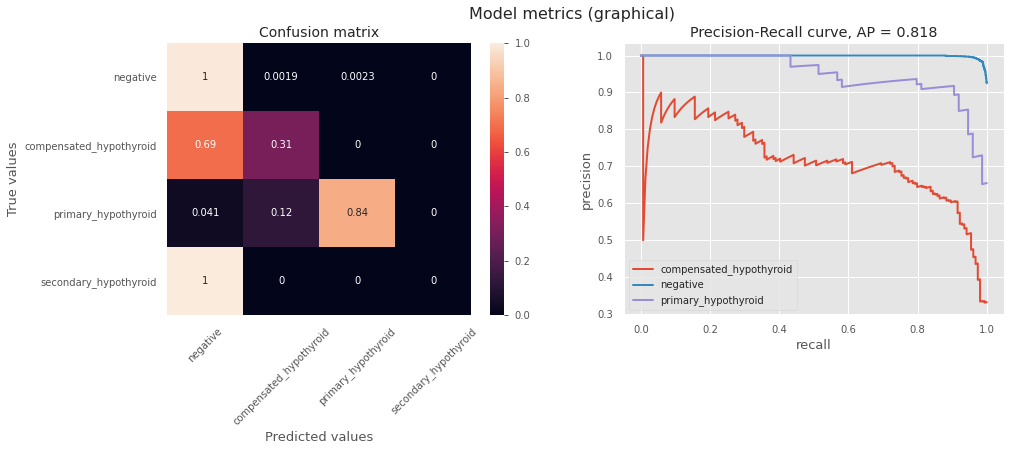

,0,1,2,3,4,Average,STD
test_AP_score,0.903412,0.907925,0.940503,0.915842,0.869696,0.907475,0.022825
test_f2_score,0.382353,0.333333,0.530612,0.413793,0.222222,0.376463,0.100837


In [ ]:
#no regularization
model = LogisticRegression();
X_tr_train = preprocessor.fit_transform(X_train);
cl = model.fit(X_tr_train,y_train);
y_pred = model.predict(X_tr_train);
y_prob = model.predict_proba(X_tr_train)
model_observe(y_train,y_pred,y_prob);
evaluate_model(model,X_tr_train,y_train)

Model perfoming is very bad on very importance classes. Let's try regularization

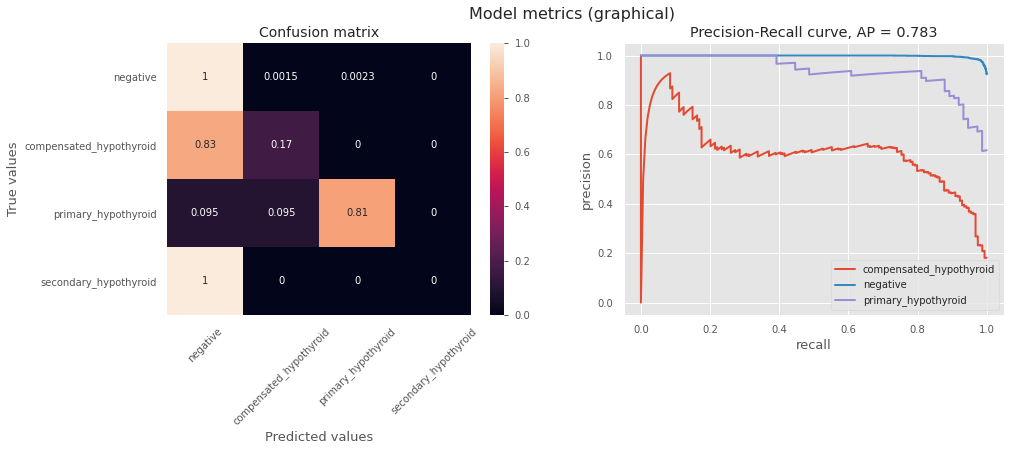

,0,1,2,3,4,Average,STD
test_AP_score,0.895106,0.900199,0.935554,0.908666,0.866667,0.901238,0.022211
test_f2_score,0.363636,0.301887,0.541667,0.357143,0.222222,0.357311,0.105212


In [ ]:
#regularization with random number, e.g. 0.2
model = LogisticRegression(C = 0.2);

cl = model.fit(X_tr_train,y_train);
y_pred = model.predict(X_tr_train);
y_prob = model.predict_proba(X_tr_train)

model_observe(y_train,y_pred,y_prob);
evaluate_model(model,X_tr_train,y_train)

Regulization parametr C=0.2 makes model even worse.
To find optimal parameter of regularization (C), GridSearch is used.


In [ ]:
C = np.logspace(0,4,10)
params = {'clf__C': [0.05, 0.1, 1, 5]}
clf = GridSearchCV(model,params,cv=5,verbose=0,scoring=make_scorer(fbeta_score,beta=2,labels=['compensated_hypothyroid','primary_hypothyroid'],average='micro'))

best_model = clf.fit(X_tr_train,y_train)
best_model.best_estimator_.get_params()


{'C': 1291.5496650148827,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
y_pred = best_model.best_estimator_.predict(X_tr_train)
y_prob = best_model.best_estimator_.predict_proba(X_tr_train)

#model_metrics(model,y_train,y_pred,y_prob);

#Cross validation 
kfold = KFold(n_splits=5,shuffle = True,random_state=SEED)

evaluate_model(best_model.best_estimator_,X_tr_train,y_train)
#using F_2 score as a scorer instead of accuracy one.

,0,1,2,3,4,Average,STD
test_AP_score,0.916576,0.927974,0.938546,0.926309,0.878914,0.917664,0.020590
test_f2_score,0.382353,0.466667,0.500000,0.426230,0.218750,0.398800,0.098273


Setting best parameters resulted in increasing f2_score and lowering STD. 

Still, this classification is very bad at diagnosting compensated_hypothyroid (which is one of the main goal of the classifier), resulting in low f2_score 

Let's try another classificator

# K-nearest neighbours

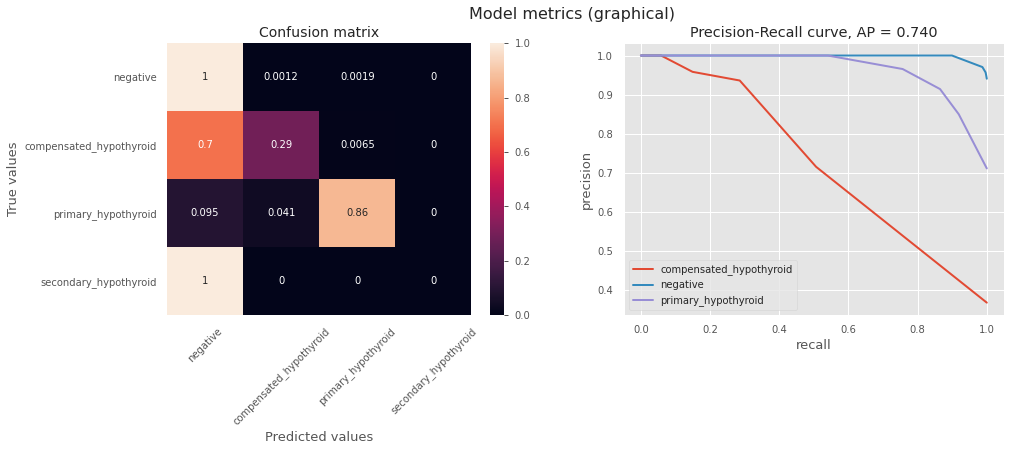

                      0         1         2  ...         4   Average       STD
test_AP_score  0.900638  0.911792  0.933916  ...  0.877372  0.907739  0.018583
test_f2_score  0.533333  0.529412  0.566038  ...  0.416667  0.518181  0.052335

[2 rows x 7 columns]


In [ ]:
model = KNeighborsClassifier();
X_tr_train = preprocessor.fit_transform(X_train);
model.fit(X_tr_train,y_train);
y_pred = model.predict(X_tr_train);
y_prob = model.predict_proba(X_tr_train)
model_observe(y_train,y_pred,y_prob);
print(evaluate_model(model,X_tr_train,y_train));

KNNeighbouts perfoms better the Logistic Regressin.

It is well known that KNN works better with few features.
According to some field research -- main indicator of hypothyroid is TSH and T4 level. Let's try model using only this features.

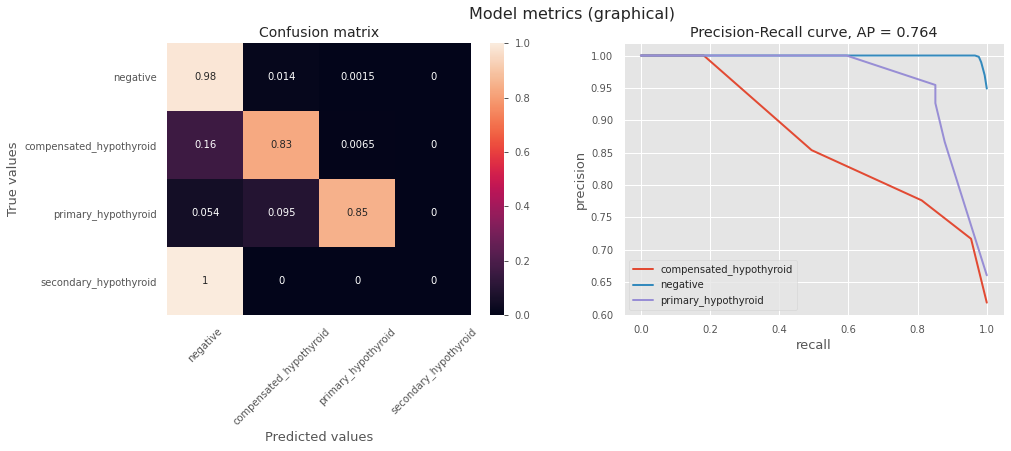

                      0         1         2  ...         4   Average       STD
test_AP_score  0.926824  0.923759  0.935877  ...  0.910474  0.928752  0.012167
test_f2_score  0.755102  0.712644  0.675676  ...  0.666667  0.720259  0.047256

[2 rows x 7 columns]


In [ ]:
model = KNeighborsClassifier();
df1 = X_train[['TSH','TT4']];
df_scaled = pd.DataFrame(numeric_transformer.fit_transform(df1));

model.fit(df_scaled,y_train);

y_pred =  model.predict(df_scaled);
y_prob = model.predict_proba(df_scaled);
model_observe(y_train,y_pred,y_prob);
res = evaluate_model(model,df_scaled,y_train);
print(res);

Much better result -- let's tune hyperparametes just like in Logistic Regression

In [ ]:

C = list(range(2,15))
hyperparams = dict(n_neighbors=C);
clf = GridSearchCV(model,hyperparams,cv=5,verbose = 0,scoring=make_scorer(fbeta_score,beta=2,labels=['compensated_hypothyroid','primary_hypothyroid','secondary_hypothyroid'],average='micro'))
best_model = clf.fit(df_scaled,y_train)
best_params = best_model.best_estimator_.get_params()



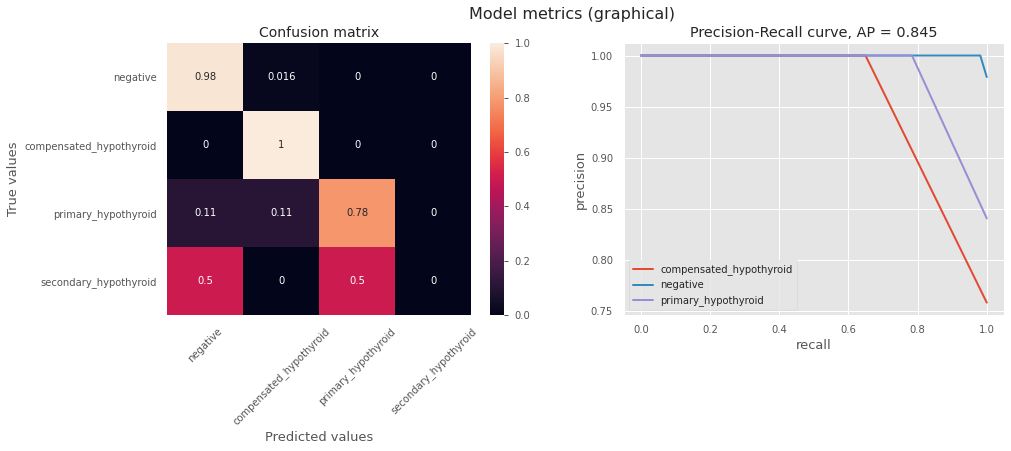

                          0
f1_beta            0.896785
average_precision  0.998254


In [ ]:

#set best params and use this model
model.set_params(**best_params)
model.fit(df_scaled,y_train)
y_pred =  model.predict(df_scaled);
y_prob = model.predict_proba(df_scaled);
model_observe(y_train,y_pred,y_prob);
res = model_metrics(y_train,y_pred,y_prob);
print(res);

This resulted in pretty good model.

#Random Forest

In KNN model requierd less features to be stronger. There is another classifier -- Random Forest which perform good with a lot of features. Let's try this classifier.

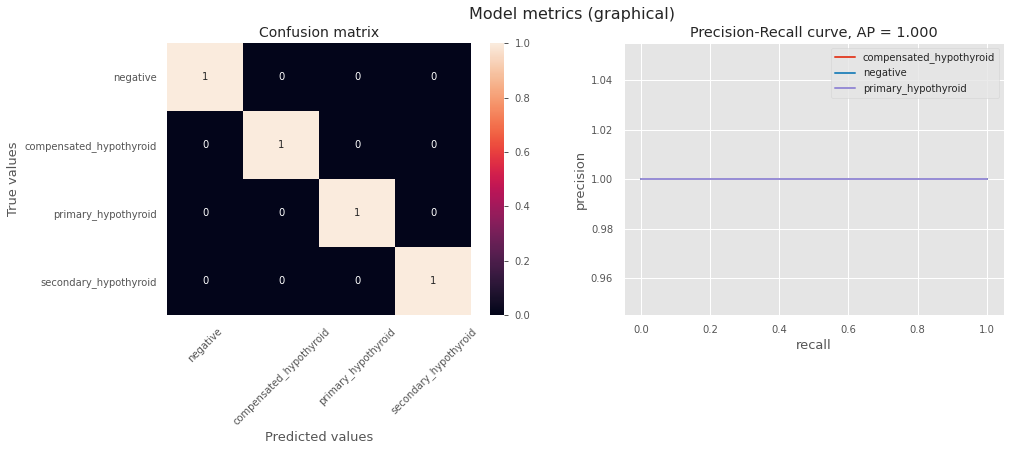

,0,1,2,3,4,Average,STD
test_AP_score,0.978985,0.989446,0.975387,0.973258,0.96929,0.977273,0.006849
test_f2_score,0.934579,0.954545,0.869565,0.891304,0.87619,0.905237,0.033474


In [ ]:
clf = RandomForestClassifier()

cl = clf.fit(X_tr_train,y_train);
y_pred = clf.predict(X_tr_train);
y_prob = clf.predict_proba(X_tr_train)

model_observe(y_train,y_pred,y_prob);
evaluate_model(clf,X_tr_train,y_train)

Wow. The pictures above are probably ilustraiting overfitting but the table below shows *cross-validation* results which are still very good and much better than both KNN and Logistic Regression. Just a simple try of new model gives the best answer.

Let's compare this two models on test set.

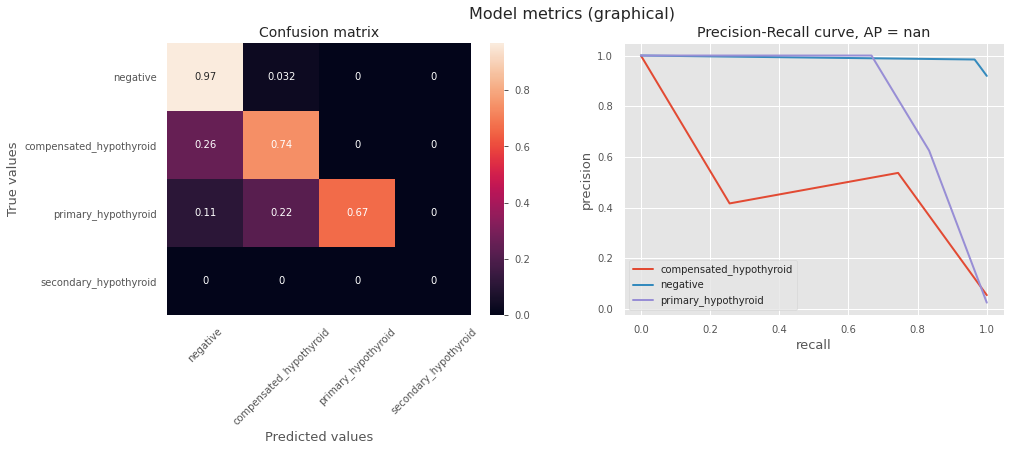

,0
f1_beta,0.697279
average_precision,0.935296


In [ ]:
df1 = X_test[['TSH','TT4']];
df_scaled = pd.DataFrame(numeric_transformer.fit_transform(df1));
y_test_pred = model.predict(df_scaled);
y_test_prob = model.predict_proba(df_scaled)

model_observe(y_test,y_test_pred,y_test_prob);
model_metrics(y_test,y_test_pred,y_test_prob)

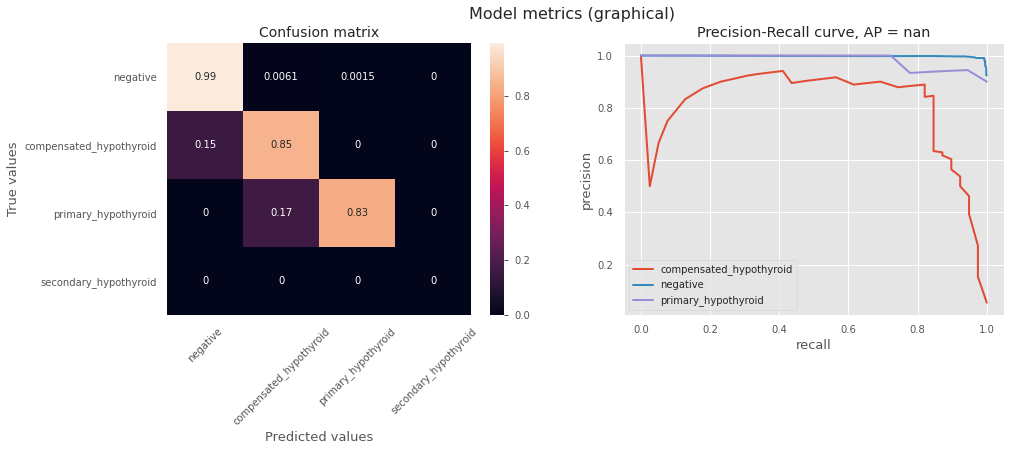

,0
f1_beta,0.845070
average_precision,0.994184


In [ ]:
X_tr_test = preprocessor.fit_transform(X_test);
y_test_pred = clf.predict(X_tr_test);
y_test_prob = clf.predict_proba(X_tr_test)

model_observe(y_test,y_test_pred,y_test_prob);
model_metrics(y_test,y_test_pred,y_test_prob)

So RandomForest perfoms much better and shows decent results on test set.